In [1]:
#Single Tensor for Observations (STfO)
#https://github.com/maximecb/gym-minigrid


from collections import deque
import gym, random, math
from tqdm import trange
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


#gym.logger.set_level(40)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip3 install gym-minigrid
from gym_minigrid.wrappers import *


In [3]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

max_env_steps = 50

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity,
        # we will deal with flattened version of state.
        
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)
        flattened_grid = full_grid.flatten()

        return flattened_grid
    
    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)

In [4]:
class DQN(nn.Module):
    input_dim = 27
    output_dim = 7
    hidden = 32
    #hidden2 = 32

    def __init__(self):
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(0)

        self.fc = nn.Sequential(     nn.Linear(self.input_dim, self.hidden),
                           nn.Tanh(),
                           nn.Linear(self.hidden,self.hidden),
                           nn.Tanh(),
                           nn.Linear(self.hidden,self.output_dim),
                            nn.Softmax(dim=-1)
                         )
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [5]:
class Agent:
    output_dim = 7
    lr = 1e-3
    batch_size = 32
    gamma = 0.99

    def __init__(self):
        self.online_net = DQN()
        self.online_net.train()

        self.target_net = DQN()
        self.update_target_net()
        for param in self.target_net.parameters(): param.requires_grad = False

        self.optimiser = optim.Adam(self.online_net.parameters(), lr=self.lr)

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return self.online_net(state).argmax(1).item()

    def act_e_greedy(self, state, epsilon=0.01):
        if random.random() < epsilon:
            return random.randrange(self.output_dim)
        else:
            return self.act(state)

    def _sample_batch(self, buffer):
        s, a, r, ns, t = zip(*random.sample(buffer, self.batch_size))
        f, l = torch.FloatTensor, torch.LongTensor
        return f(s), l(a), f(r), f(ns), f(t)

    def train_iter(self, buffer):
        state, action, reward, next_state, terminal = self._sample_batch(buffer)

        q_value = self.online_net(state)[range(self.batch_size), action]
        with torch.no_grad():
            next_state_action = self.online_net(next_state).max(1)[1] # online_net to get action for next_state
            next_qv = self.target_net(next_state)[range(self.batch_size), next_state_action] # target_net to get Q
            target_qv = reward + self.gamma * (1 - terminal) * next_qv
    
        loss = (q_value - target_qv).pow(2).mean()

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        return loss.item()

    def update_target_net(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

In [6]:
env_name='MiniGrid-Empty-5x5-v0'
env=FlatObsWrapper(gym.make(env_name))
env.seed(0)

action = env.actions.right
obs, reward, done, info = env.step(action)
img = env.render('rgb_array')

print('Observation:', obs, ', Observation Shape: ', obs.shape)
print('Reward:', reward)
print('Done:', done)
print('Info:', info)

Observation: [10  0  1  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  8  1  0] , Observation Shape:  (27,)
Reward: 0
Done: False
Info: {}


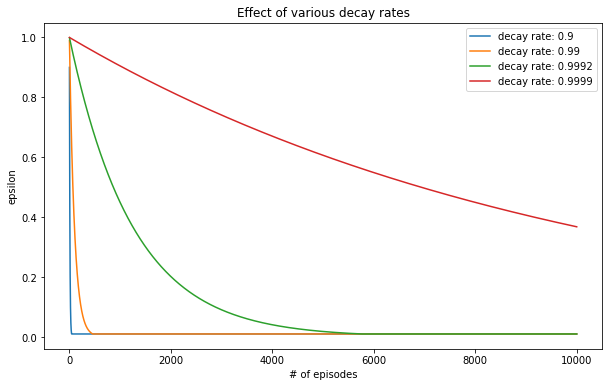

In [7]:
MAX_EPISODES = 10000
EPS_START = 1.0      # Default/starting value of eps
EPS_MIN = 0.01 

#0.998
EPS_DECAY_RATES = [0.9, 0.99, 0.9992, 0.9999]
plt.figure(figsize=(10,6))

for decay_rate in EPS_DECAY_RATES:
    test_eps = EPS_START
    eps_list = []
    for _ in range(MAX_EPISODES):
        test_eps = max(test_eps * decay_rate, EPS_MIN)
        eps_list.append(test_eps)          
    
    plt.plot(eps_list, label='decay rate: {}'.format(decay_rate))

plt.title('Effect of various decay rates')
plt.legend(loc='best')
plt.xlabel('# of episodes')
plt.ylabel('epsilon')
plt.show()

In [ ]:
EPS_START = 1.0      # Default/starting value of eps
EPS_DECAY = 0.9992  # Epsilon decay rate 0.999
EPS_MIN = 0.01 
eps = EPS_START


buffer = deque(maxlen=5000)#
agent = Agent()

rewards, loss = [], []
episode_reward = 0
state = env.reset()

for i in range(10000):
    action = agent.act_e_greedy(state, eps)
    next_state, reward, done, _ = env.step(action)
    buffer.append((state, action, reward, next_state, done))
    eps = max(eps * EPS_DECAY, EPS_MIN)
  
    state = next_state
    episode_reward += reward

    if done:
        state = env.reset()
        rewards.append(episode_reward)
        episode_reward = 0
    
    if i > 100:
        loss.append(agent.train_iter(buffer))
   
    if i > 100 and i % 100 == 0:
        agent.update_target_net()

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(rewards)
plt.subplot(132)
plt.plot(loss)

In [ ]:
env_name='MiniGrid-Empty-5x5-v0'
env=FlatObsWrapper(gym.make(env_name))
env.seed(0)

for i in range(1):
    score = 0
    state = env.reset()
    scores = []
    a = 0
    while True:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        img = env.render('rgb_array')
        plt.imshow(np.concatenate([img], 1))
        plt.show()

        state = next_state        
        score += reward
        #print(score)
        scores = np.append(scores,score)
        a= a+1
        if done:
            break

    print('episode: {} scored {}'.format(i, score))